# Мультиклассовая Логистическая Регрессия
Rак выполняется не-бинарная классификация с помощью логистической регрессии? Сделать это в scikit-learn можно практически точно так же, как и в случае бинарной классификации. Рассмотрим этот процесс на простом наборе данных, а также посмотрим, как использовать LogisticRegression с применением GridSearchCV (вместо LogisticRegressionCV).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Данные
Классический набор данных Iris Data Set. Это цветки Ириса, и набор данных о них был создан британским биологом Рональдом Фишером в 1936 году.

Более подробно об этом наборе данных можно прочитать в этой [статье]( https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0).

**ЗАДАЧА: построить новую модель, для которой можно взять новый цветок, измерить для него чашелистик и лепесток и получить на основе этих данных предсказание модели - к какому из трёх видов относится этот цветок.**

In [5]:
df = pd.read_csv('../DATA/iris.csv')
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


## Анализ и визуализация данных

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [10]:
df.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [12]:
df['species'].value_counts()

species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

Мы видим три вида цветков и для каждого из них по 50 строк, т.е. классы идеально сбалансированы между собой.

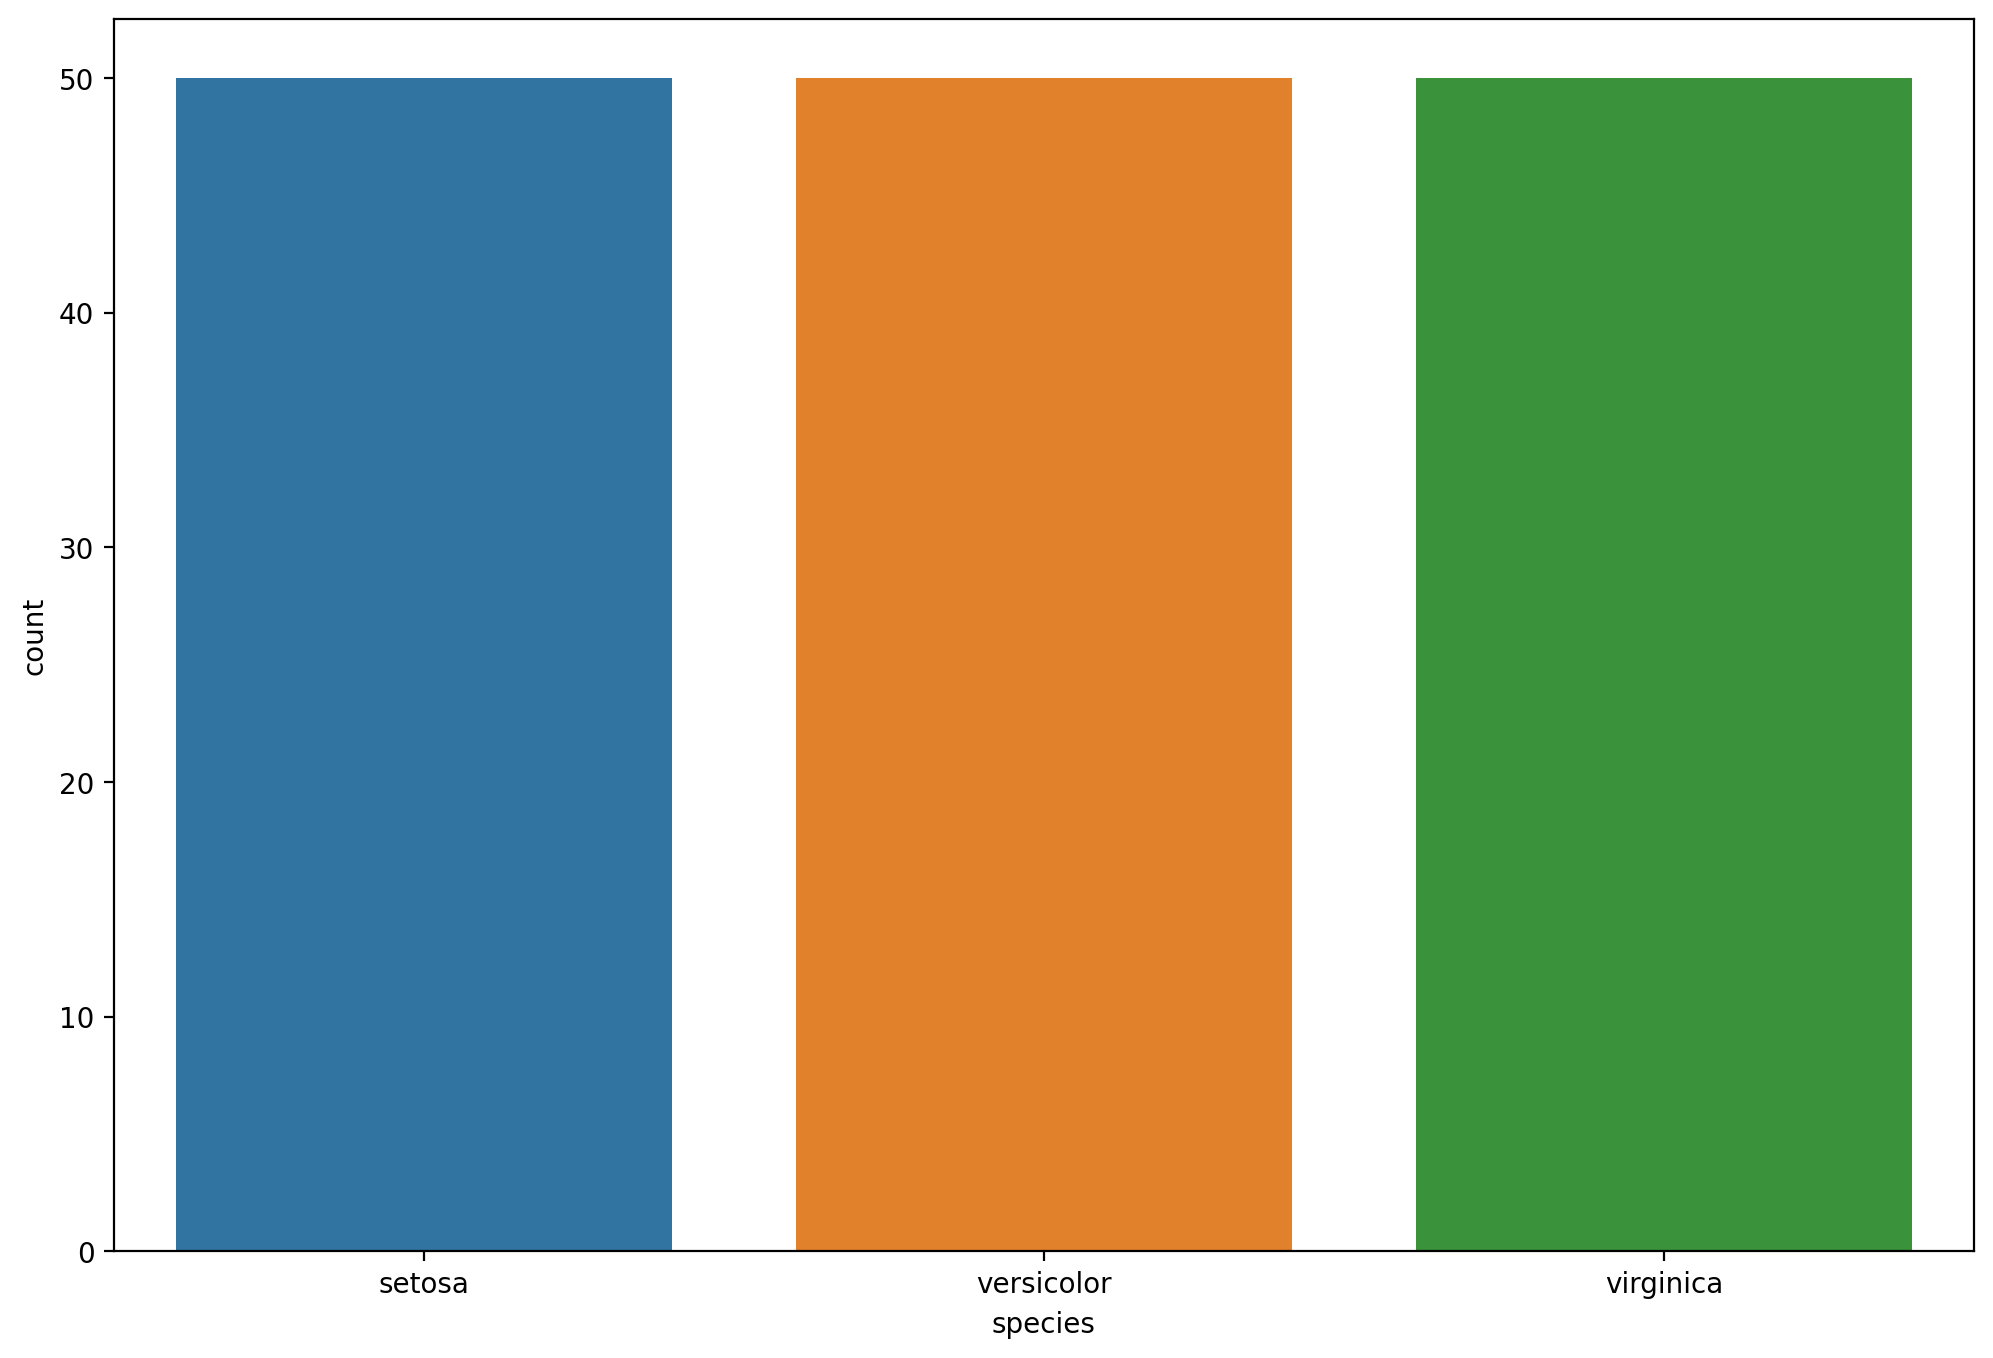

In [17]:
plt.figure(figsize=(12, 8), dpi=200)
sns.countplot(data=df, x='species', hue='species')
plt.show()

Посмотрим на связь двух переменных *petal_length* и *petal_width* - длина и ширина лепестков.

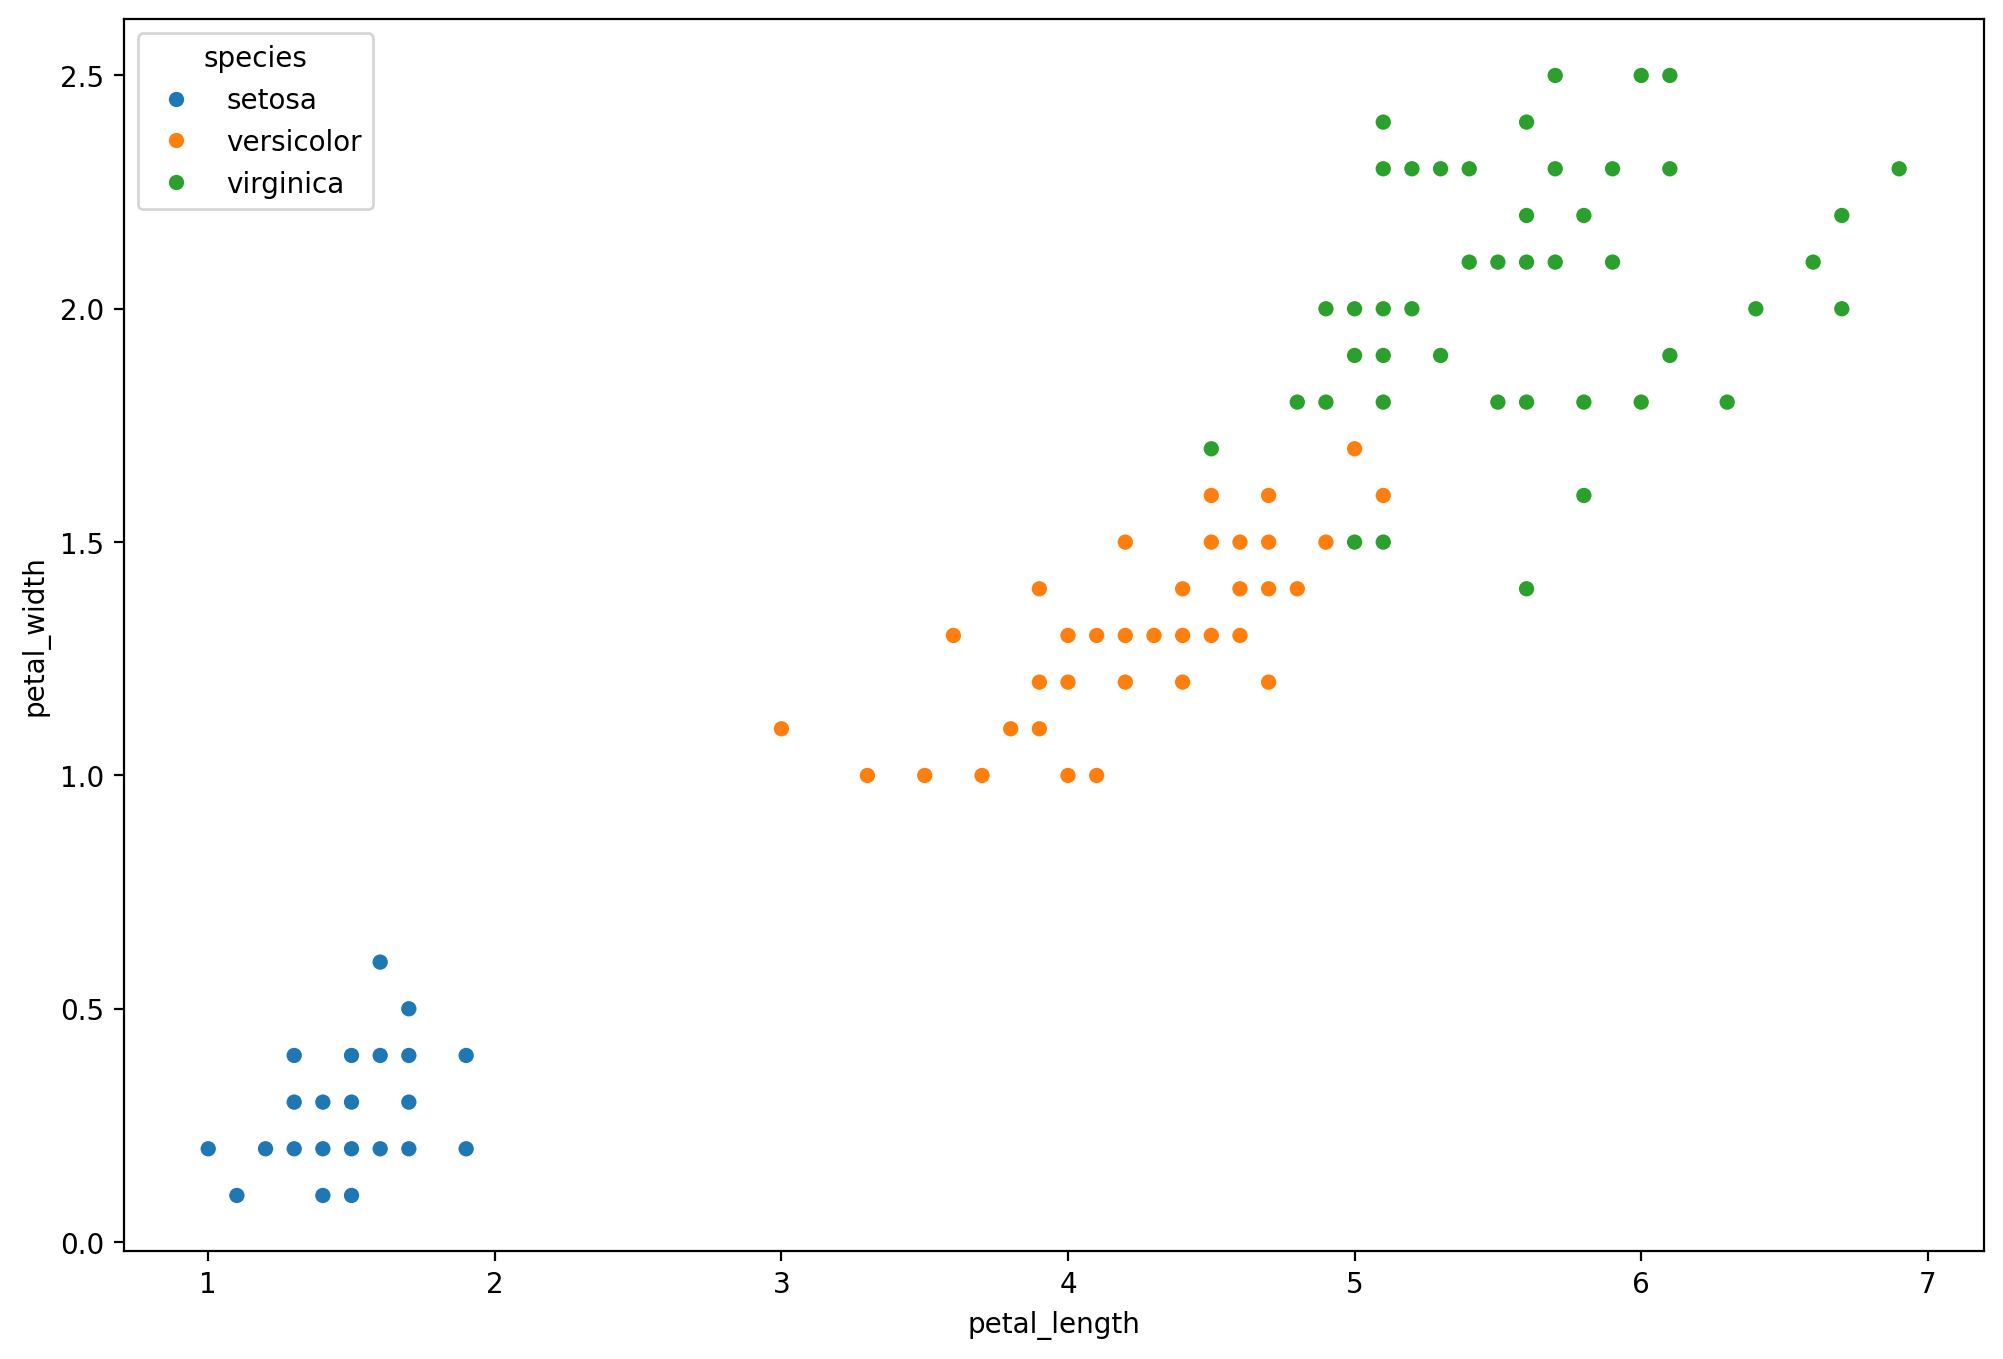

In [21]:
plt.figure(figsize=(12, 8), dpi=200)
sns.scatterplot(data=df, x='petal_length', y='petal_width', hue='species')
plt.show()

На этом графике видно достаточно чёткие тренды для всех трёх видов. Однако *versicolor* и *virginica* достаточно близки друг к другу, так что может возникнуть сложность в отделении их друг от друга. Это может зависеть от того, каким образом будут разбиваться данные на обучающий и тестовый наборы.

<Figure size 2400x1600 with 0 Axes>

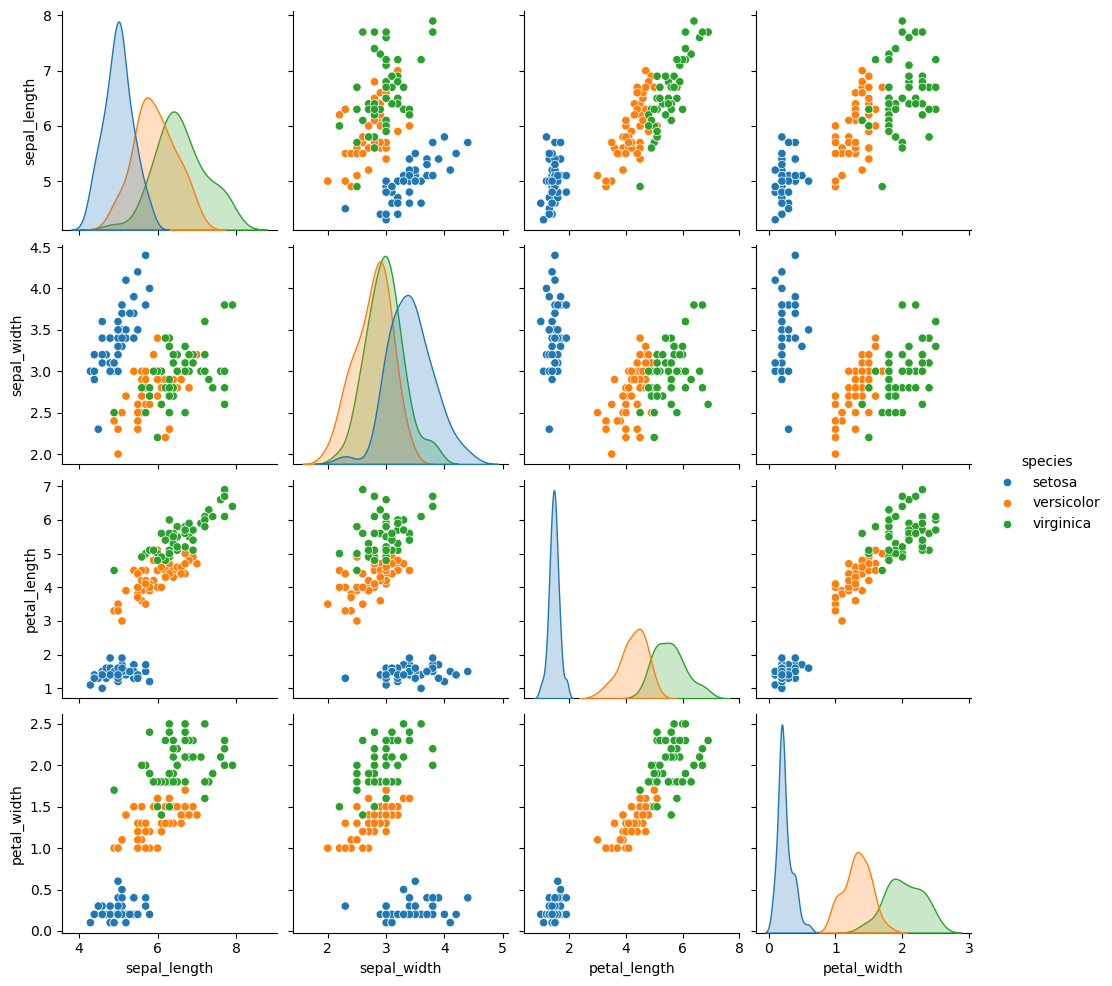

In [24]:
plt.figure(figsize=(12, 8), dpi=200)
sns.pairplot(data=df, hue='species')
plt.show()

На всех этих графиках *setosa* хорошо отделяется от других видов, а *versicolor* и *virginica* очень близки друг к другу.

**Посмотрим на корреляцию признаков**

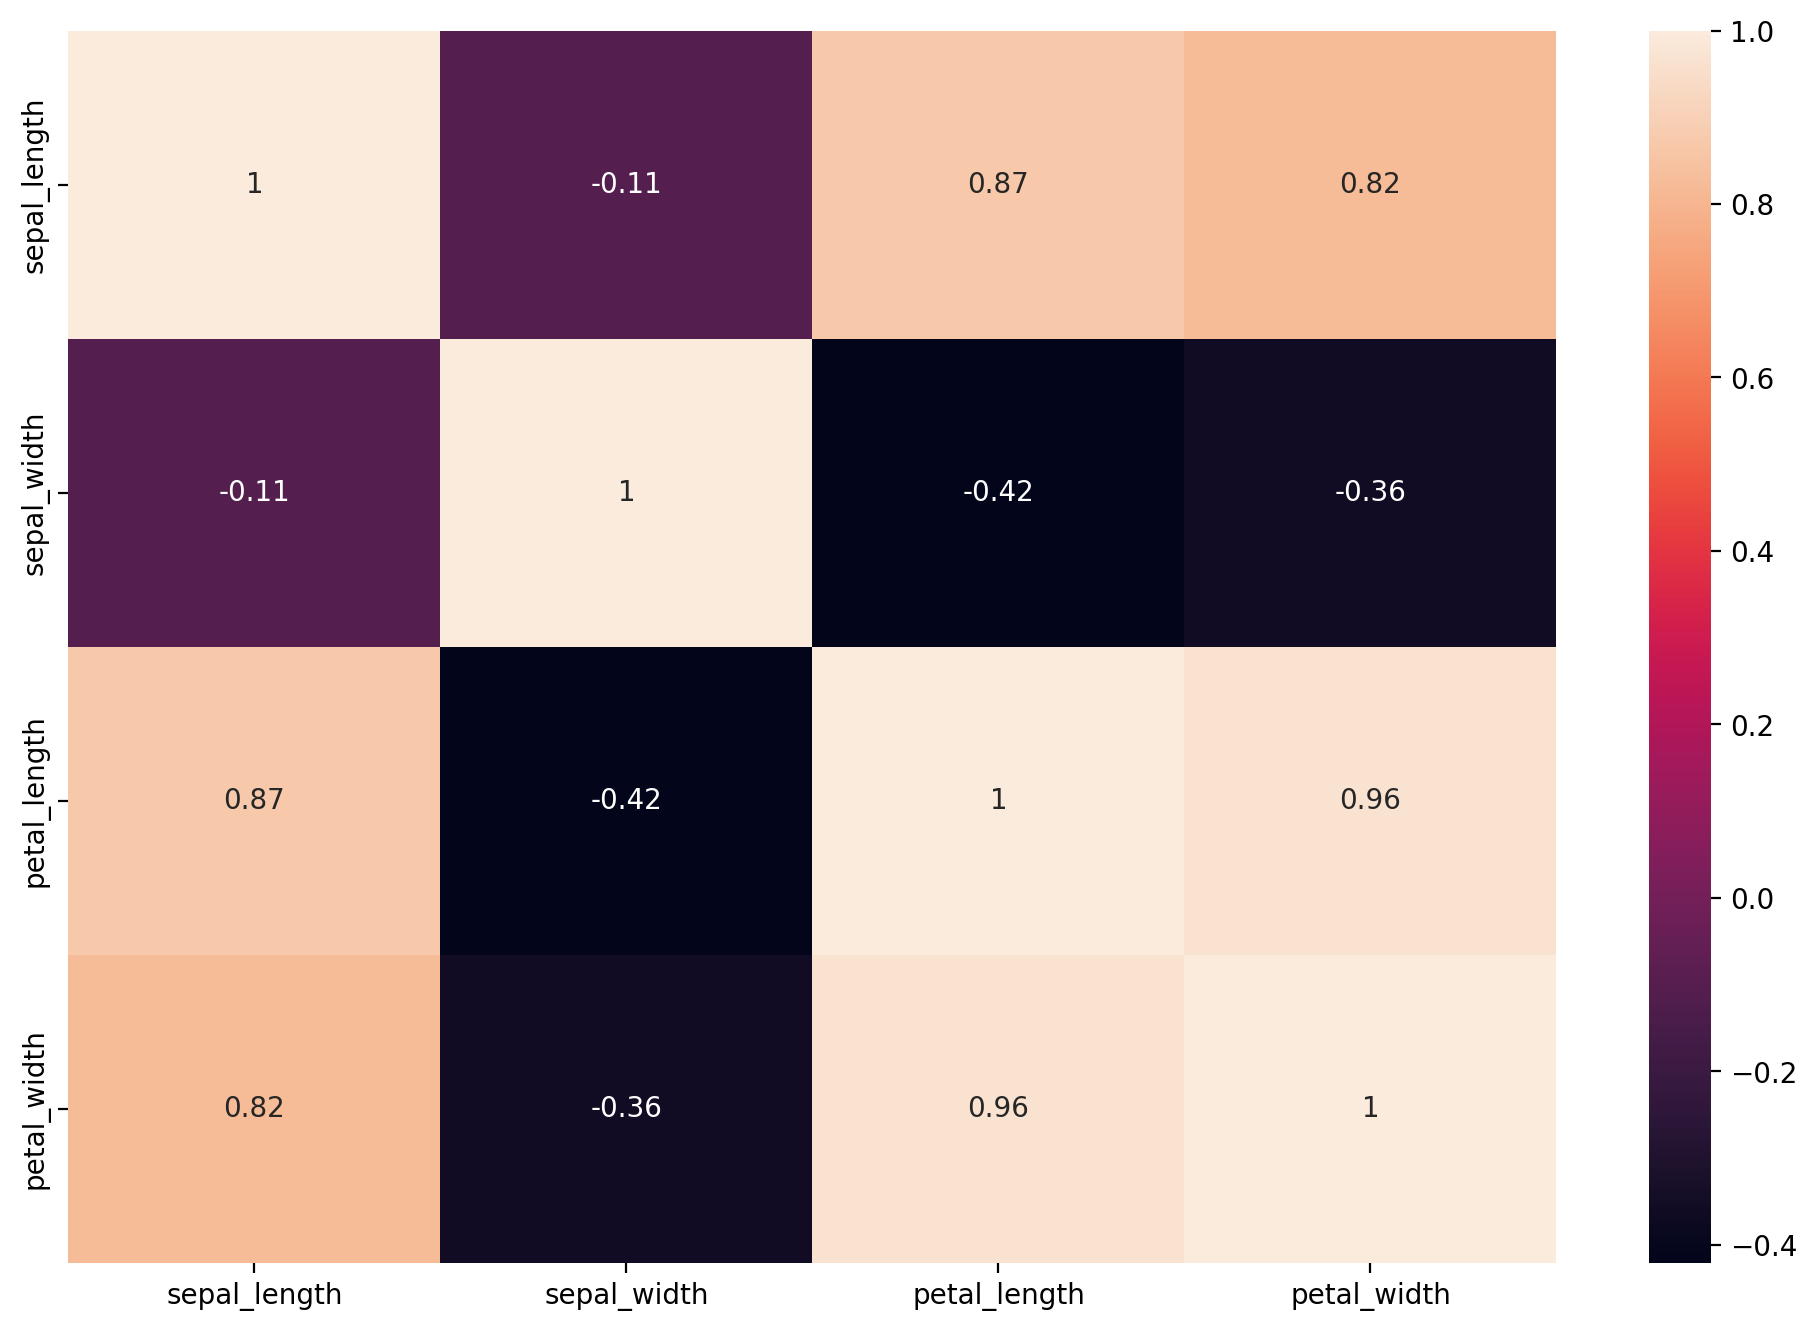

In [29]:
plt.figure(figsize=(12, 8), dpi=200)
sns.heatmap(df.corr(numeric_only=True), annot=True)
plt.show()

*petal_length* и *petal_width* достаточно сильно коррелируют с *sepal_length*(длиной чашелистика), т.е. чем больше лепестки, тем больше чашелистик - весь цветок больше по размеру.

In [32]:
df['species'].unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

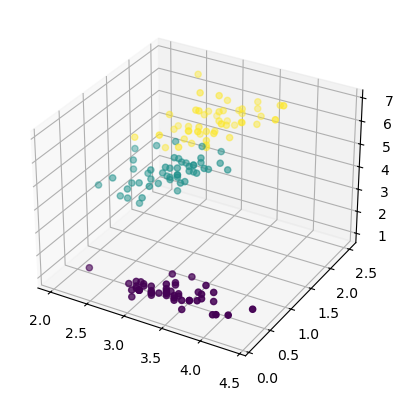

In [34]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = df['species'].map({'setosa':0, 'versicolor':1, 'virginica':2})
ax.scatter(df['sepal_width'], df['petal_width'], df['petal_length'], c=colors)

## Подготовка данных

### Разбиение данных

In [38]:
X =df.drop('species', axis=1)
y = df['species']

In [40]:
from sklearn.model_selection import train_test_split

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

### Масштабирование признаков

In [45]:
from sklearn.preprocessing import StandardScaler

In [47]:
scaler = StandardScaler()

In [49]:
scaled_X_train = scaler.fit_transform(X_train)

In [51]:
scaled_X_test = scaler.transform(X_test)

## Модель мультиклассовой логистической регрессии

In [54]:
from sklearn.linear_model import LogisticRegression

In [56]:
from sklearn.model_selection import GridSearchCV

Когда классов несколько, то для каждого класса применяется следующий подход - берётся отдельно этот класс и отдельно всё остальное:

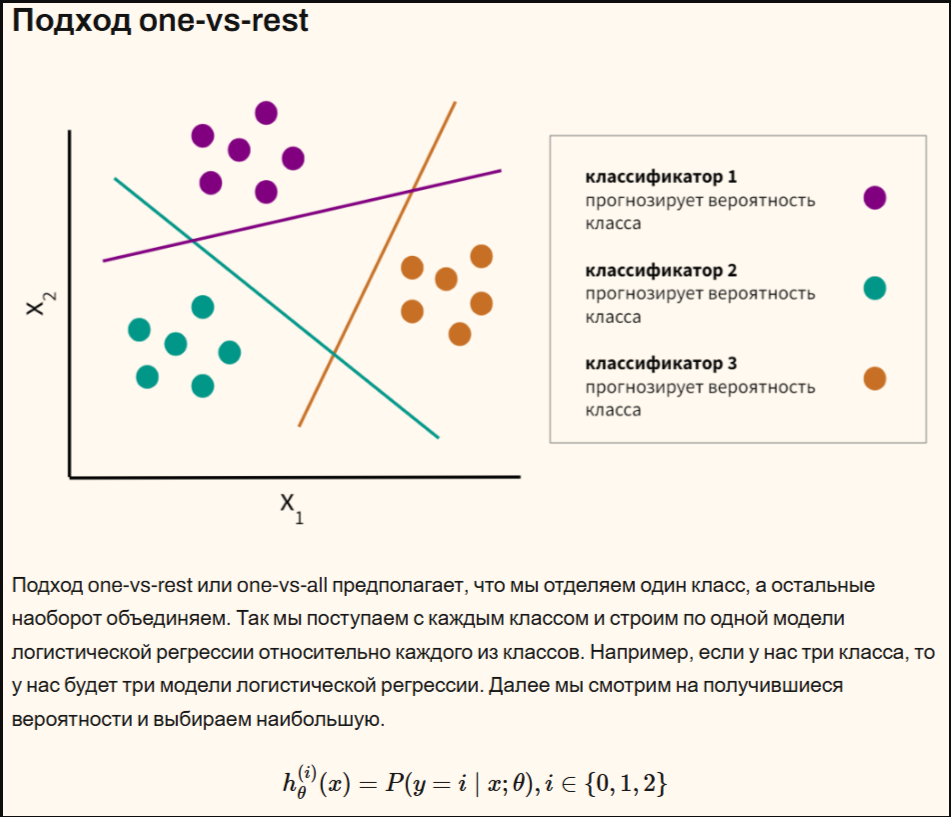

Мы берем какой-то один класс и учимся отделять его от остальных, затем берем второй и уже учимся отделять его - это происходит для всех имеющихся классов.

Для каждой методологии `multiclass`, подходят определённые параметры `solver`.

In [59]:
from sklearn.multiclass import OneVsRestClassifier

In [61]:
# В зависимости от предупреждений, возможно придётся 
# поменять максимальное количество итераций
# Или же поэкспериментировать с другими объектами solver
log_model = LogisticRegression(solver='saga', max_iter=5000)
log_model_ovr = OneVsRestClassifier(log_model)

In [63]:
penalty = ['l1', 'l2', 'elasticnet']
l1_ratio = np.linspace(0, 1, 20)
# Используем логарифмически отстоящие друг от друга значения C (рекомендовано в официальной документации)
C = np.logspace(0, 10, 20)

param_grid = {'estimator__penalty': penalty,
              'estimator__l1_ratio': l1_ratio,
              'estimator__C': C}

In [69]:
grid_model = GridSearchCV(log_model_ovr, param_grid=param_grid)

In [71]:
grid_model.fit(scaled_X_train, y_train)

D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio paramet

GridSearchCV(estimator=OneVsRestClassifier(estimator=LogisticRegression(max_iter=5000,
                                                                        solver='saga')),
             param_grid={'estimator__C': array([1.00000000e+00, 3.35981829e+00, 1.12883789e+01, 3.79269019e+01,
       1.27427499e+02, 4.28133240e+02, 1.43844989e+03, 4.83293024e+03,
       1.62377674e+04, 5.45559478e+04, 1.83298071e+05, 6.15848211e+05,
       2.06913808e+06, 6.95192796e+06, 2.33...0e+07,
       2.63665090e+08, 8.85866790e+08, 2.97635144e+09, 1.00000000e+10]),
                         'estimator__l1_ratio': array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
                         'estimator__penalty': ['l1', 'l2', 'elasticnet']})

In [73]:
grid_model.best_params_

{'estimator__C': 11.28837891684689,
 'estimator__l1_ratio': 0.0,
 'estimator__penalty': 'l1'}

## Оценка модели в задачах классификации

In [76]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [78]:
y_pred = grid_model.predict(scaled_X_test)

In [80]:
y_pred

array(['setosa', 'setosa', 'setosa', 'virginica', 'versicolor',
       'virginica', 'versicolor', 'versicolor', 'virginica', 'setosa',
       'virginica', 'setosa', 'setosa', 'virginica', 'virginica',
       'versicolor', 'versicolor', 'versicolor', 'setosa', 'versicolor',
       'versicolor', 'setosa', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'virginica', 'setosa', 'setosa',
       'virginica', 'versicolor', 'virginica', 'versicolor', 'virginica',
       'versicolor', 'versicolor', 'versicolor'], dtype='<U10')

In [82]:
accuracy_score(y_test, y_pred)

0.9736842105263158

**Так как это очень маленький набор данных, то, в случае если разбиение данных было бы сделано как-то по-другому, можно было бы получить Accuracy 100%.**

In [85]:
confusion_matrix(y_test, y_pred)

array([[10,  0,  0],
       [ 0, 17,  0],
       [ 0,  1, 10]], dtype=int64)

Видим, что модель идеально отработала во всех случаях, кроме какого-то одного.

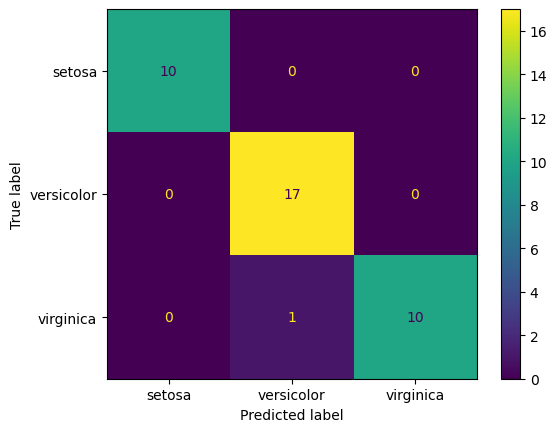

In [88]:
ConfusionMatrixDisplay.from_estimator(grid_model, scaled_X_test, y_test)

Видим те же самые данные, лишь один случай был классифицирован неправильно. Это цветок *virginica*, который был ошибочно классифицирован как *versicolor*.

In [92]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.94      1.00      0.97        17
   virginica       1.00      0.91      0.95        11

    accuracy                           0.97        38
   macro avg       0.98      0.97      0.97        38
weighted avg       0.98      0.97      0.97        38



Для класса *setosa* все метрики являются идеальными, потому что он легко отделяется от двух остальных.

## Оцениваем линию кривой (curve) и область под линией (AUC - area under the curve)
В случае нескольких классов мы должны рисовать графики вручную. К счастью, в документации Scikit-learn уже есть много примеров.

Источник: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
Ниже приведена функция, которая создаёт и рисует графики [ROC-кривых](https://ru.wikipedia.org/wiki/ROC-%D0%BA%D1%80%D0%B8%D0%B2%D0%B0%D1%8F) для каждого класса.

In [136]:
from sklearn.metrics import roc_curve, auc

In [138]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(5,5)):
    y_score = clf.decision_function(X_test)

    # создаём пустые структуры
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # один раз вычисляем dummies 
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc для каждого класса
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

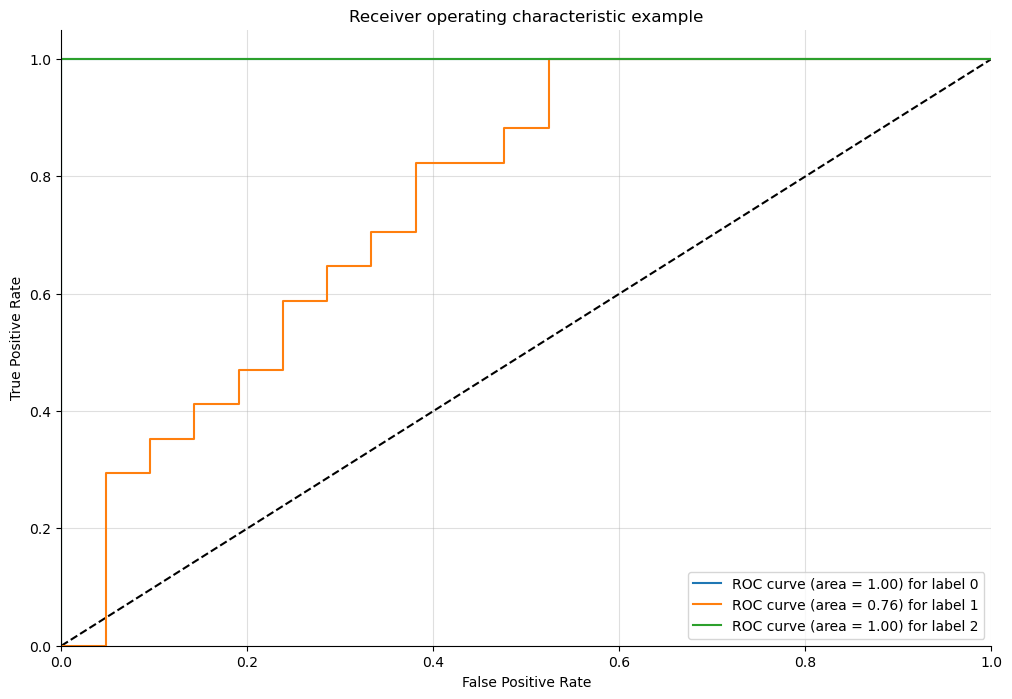

In [140]:
plot_multiclass_roc(grid_model, scaled_X_test, y_test, n_classes=3, figsize=(12, 8))

Здесь мы получаем идеальный график для *setosa*(label 2) - False Positive = 0, а True Positive = 1(или 100%).

Также получаем идальный график для одного из оставшихся классов и только для одного из трёх классов мы получаем ступенчатый график, потому что модель классифицировала все точки правильно, кроме одной точки в классе *virginica*.

В более сложных задачах, эти графики не будут выглядеть настолько близко к идеальной картине.